In [1]:
import numpy as np
import glob as gb
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import resize


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
TRAIN_PATH ='images/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

train_ids = gb.glob(TRAIN_PATH+'*.png')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    img = imread(id_)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    X_train[n] = img 

100%|██████████████████████████████████████████████████████████████████████████████| 1192/1192 [00:43<00:00, 27.35it/s]


In [6]:
TRAIN_PATH ='masks/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
train_ids = gb.glob(TRAIN_PATH+'*.png')
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    mask = imread(id_)[:,:,:1] 
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    Y_train[n] = mask 
    

100%|██████████████████████████████████████████████████████████████████████████████| 1192/1192 [00:17<00:00, 68.05it/s]


In [7]:
TRAIN_PATH ='collages/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
train_ids = gb.glob(TRAIN_PATH+'*.jpg')
X_test = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    img = imread(id_)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    X_test[n] = img 

100%|██████████████████████████████████████████████████████████████████████████████| 1192/1192 [01:11<00:00, 16.66it/s]


In [8]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_loss',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [9]:
import segmentation_models as sm

preprocess_input=sm.get_preprocessing('resnet34')
X_train=preprocess_input(X_train)
sm.set_framework('tf.keras')
sm.framework()
model=sm.Unet(backbone_name='resnet34',input_shape=(256,256,3),classes=1,activation='sigmoid',encoder_weights='imagenet')



Segmentation Models: using `keras` framework.


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']   

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history=model.fit(X_train,Y_train,epochs=15,batch_size=16,validation_split=0.1,steps_per_epoch=len(X_train)//16,
                 callbacks=callback,verbose=1)


Epoch 1/15
74/74 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9783
Epoch 1: val_loss improved from inf to 0.15426, saving model to model.hdf5
74/74 [==============================] - 55s 334ms/step - loss: 0.1044 - accuracy: 0.9783 - val_loss: 0.1543 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 2/15
74/74 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9917
Epoch 2: val_loss improved from 0.15426 to 0.04236, saving model to model.hdf5
74/74 [==============================] - 22s 299ms/step - loss: 0.0367 - accuracy: 0.9917 - val_loss: 0.0424 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/15
74/74 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9944
Epoch 3: val_loss improved from 0.04236 to 0.02229, saving model to model.hdf5
74/74 [==============================] - 21s 285ms/step - loss: 0.0230 - accuracy: 0.9944 - val_loss: 0.0223 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 4/15
74/74 [==============================] 

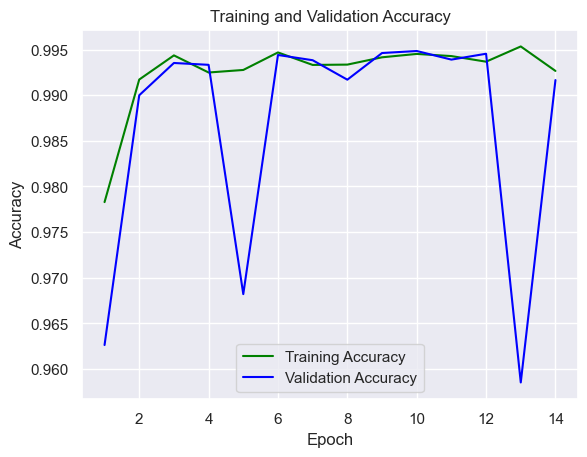

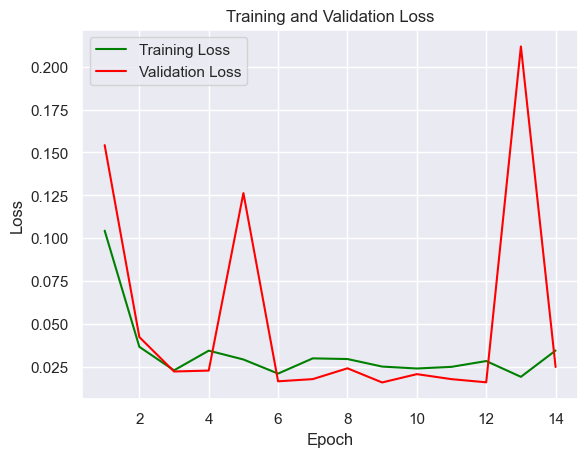

In [11]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.figure()


#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

38/38 [==============================] - 10s 126ms/step


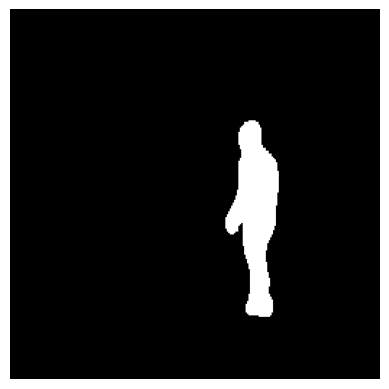

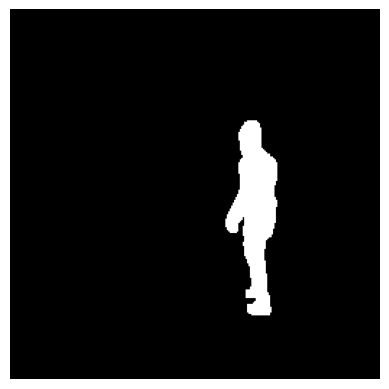

In [12]:
y_pred=model.predict(X_train)
y_pred_p=(y_pred > 0.5).astype(np.uint8)
plt.imshow(y_pred_p[100],cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(Y_train[100],cmap='gray')
plt.axis('off')
plt.show()